# Image translation
---

Written by Ziwen Liu and Shalin Mehta, CZ Biohub San Francisco.

In this exercise, we will solve an image translation task to predict fluorescence images of nuclei and membrane markers from quantitative phase images of cells. In other words, we will _virtually stain_ the nuclei and membrane visible in the phase image. 

Here, the source domain is label-free microscopy (material density) and the target domain is fluorescence microscopy (fluorophore density). The goal is to learn a mapping from the source domain to the target domain. We will use a deep convolutional neural network (CNN), specifically, a U-Net model with residual connections to learn the mapping. The preprocessing, training, prediction, evaluation, and deployment steps are unified in a computer vision pipeline for single-cell analysis that we call [VisCy](https://github.com/mehta-lab/VisCy).

VisCy evolved from our previous work on virtual staining of cellular components from their density and anisotropy.
![](https://iiif.elifesciences.org/lax/55502%2Felife-55502-fig1-v2.tif/full/1500,/0/default.jpg)

[Guo et al. (2020) Revealing architectural order with quantitative label-free imaging and deep learning
. eLife](https://elifesciences.org/articles/55502).

VisCy exploits recent advances in the data and metadata formats ([OME-zarr](https://www.nature.com/articles/s41592-021-01326-w)) and DL frameworks, [PyTorch Lightning](https://lightning.ai/) and [MONAI](https://monai.io/). Our previous pipeline, [microDL](https://github.com/mehta-lab/microDL), is deprecated and is now a public archive.

Today, we will train a 2D image translation model using a 2D U-Net with residual connections. We will use a dataset of 301 fields of view (FOVs) of Human Embryonic Kidney (HEK) cells, each FOV has 3 channels (phase, membrane, and nuclei). The cells were labeled with CRISPR editing. Intrestingly, not all cells during this experiment were labeled due to the stochastic nature of CRISPR editing. In such situations, virtual staining rescues missing labels.
![HEK](https://github.com/mehta-lab/VisCy/blob/dlmbl2023/docs/figures/phase_to_nuclei_membrane.svg?raw=true)

<div class="alert alert-info">
The exercise is organized in 3 parts.

* **Part 1** - Explore the data using tensorboard. Launch the training before lunch.
* Lunch break - The model will continue training during lunch.
* **Part 2** - Evaluate the training with tensorboard. Train another model.
* **Part 3** - Tune the models to improve performance.
</div>

📖 As you work through parts 2 and 3, please share the layouts of your models (output of torchview) and their performance with everyone via [this google doc](https://docs.google.com/document/d/1hZWSVRvt9KJEdYu7ib-vFBqAVQRYL8cWaP_vFznu7D8/edit#heading=h.n5u485pmzv2z) 📖.


Our guesstimate is that each of the three parts will take ~1.5 hours. A reasonable 2D UNet can be trained in ~20 min on a typical AWS node. 
We will discuss your observations on google doc after checkpoints 2 and 3.

The focus of the exercise is on understanding information content of the data, how to train and evaluate 2D image translation model, and explore some hyperparameters of the model. If you complete this exercise and have time to spare, try the bonus exercise on 3D image translation.

There are a few coding tasks sprinkled in parts 1 and 2, but part 3 is where you start writing and debugging code in the earnest. Before you start,

<div class="alert alert-danger">
Set your python kernel to <span style="color:black;">04-image-translation</span>
</div>

# Part 1: Log training data to tensorboard, start training a model.
---------

Learning goals:

- Load the OME-zarr dataset and examine the channels.
- Configure and understand the data loader.
- Log some patches to tensorboard.
- Initialize a 2D U-Net model for virtual staining
- Start training the model to predict nuclei and membrane from phase.

In [1]:

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchview
import torchvision
from iohub import open_ome_zarr
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from skimage import metrics  # for metrics.

# pytorch lightning wrapper for Tensorboard.
from torch.utils.tensorboard import SummaryWriter  # for logging to tensorboard

# HCSDataModule makes it easy to load data during training.
from viscy.light.data import HCSDataModule

# Trainer class and UNet.
from viscy.light.engine import VSTrainer, VSUNet

seed_everything(42, workers=True)

# Paths to data and log directory
data_path = Path(
    Path("~/data/04_image_translation/HEK_nuclei_membrane_pyramid.zarr/")
).expanduser()

log_dir = Path("~/data/04_image_translation/logs/").expanduser()

# Create log directory if needed, and launch tensorboard
log_dir.mkdir(parents=True, exist_ok=True)

# fmt: off
%reload_ext tensorboard
%tensorboard --logdir {log_dir}
# change the hostname to your amazon aws instance.
# fmt: on

Global seed set to 42


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
/home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.29' not found (required by /home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by /home/parkh/conda/envs/04_image_translation/lib/python3.10/site-packages/tensorbo

Above cell starts tensorboard within the notebook.

<div class="alert alert-danger">
If you launched jupyter lab from ssh terminal, you do need the <code>--host &lt;hostname&gt;</code> flag above. <code>&lt;hostname&gt;</code> is the address of your compute node that ends in amazonaws.com.

You can also launch tensorboard in an independent tab by changing the `%` to `!`
</div>

## Load Dataset.

<div class="alert alert-info">
Task 1.1
Use <a href=https://czbiohub-sf.github.io/iohub/main/api/ngff.html#open-ome-zarr>
<code>iohub.open_ome_zarr</code></a> to read the dataset and explore several FOVs with matplotlib.
</div>

There should be 301 FOVs in the dataset (12 GB compressed).

Each FOV consists of 3 channels of 2048x2048 images,
saved in the <a href="https://ngff.openmicroscopy.org/latest/#hcs-layout">
High-Content Screening (HCS) layout</a>
specified by the Open Microscopy Environment Next Generation File Format
(OME-NGFF).

The layout on the disk is: row/col/field/pyramid_level/timepoint/channel/z/y/x.
Notice that labelling of nuclei channel is not complete - some cells are not expressing the fluorescent protein.

Number of positions: 301
data shape: (1, 3, 1, 2048, 2048), FOV: 23, pyramid level: 0


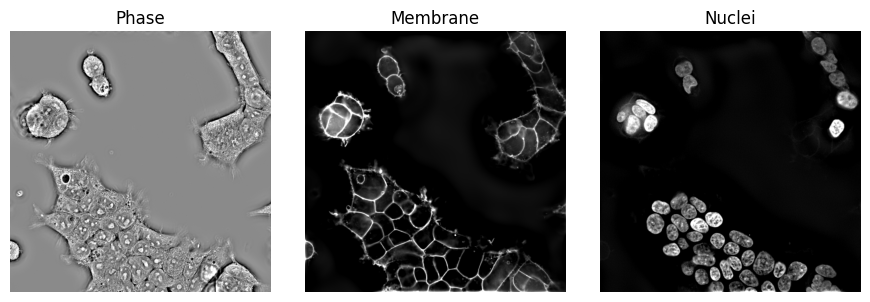

In [2]:

dataset = open_ome_zarr(data_path)

print(f"Number of positions: {len(list(dataset.positions()))}")

# Use the field and pyramid_level below to visualize data.
row = 0
col = 0
field = 23  # TODO: Change this to explore data.

# This dataset contains images at 3 resolutions.
# '0' is the highest resolution
# '1' is down-scaled 2x2,
# '2' is down-scaled 4x4.
# Such datasets are called image pyramids.
pyaramid_level = 0

# `channel_names` is the metadata that is stored with data according to the OME-NGFF spec.
n_channels = len(dataset.channel_names)

image = dataset[f"{row}/{col}/{field}/{pyaramid_level}"].numpy()
print(f"data shape: {image.shape}, FOV: {field}, pyramid level: {pyaramid_level}")

figure, axes = plt.subplots(1, n_channels, figsize=(9, 3))

for i in range(n_channels):
    for i in range(n_channels):
        channel_image = image[0, i, 0]
        # Adjust contrast to 0.5th and 99.5th percentile of pixel values.
        p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
        channel_image = np.clip(channel_image, p_low, p_high)
        axes[i].imshow(channel_image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(dataset.channel_names[i])
plt.tight_layout()

## Explore the effects of augmentation on batch.

<div class="alert alert-info">
Task 1.2
Setup the data loader and log several batches to tensorboard.
</div>`

VisCy builds on top of PyTorch Lightning. PyTorch Lightning is a thin wrapper around PyTorch that allows rapid experimentation. It provides a [DataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) to handle loading and processing of data during training. VisCy provides a child class, `HCSDataModule` to make it intuitve to access data stored in the HCS layout.
  
The dataloader in `HCSDataModule` returns a batch of samples. A `batch` is a list of dictionaries. The length of the list is equal to the batch size. Each dictionary consists of following key-value pairs.
- `source`: the input image, a tensor of size 1*1*Y*X
- `target`: the target image, a tensor of size 2*1*Y*X
- `index` : the tuple of (location of field in HCS layout, time, and z-slice) of the sample.

In [3]:
# Define a function to write a batch to tensorboard log.

def log_batch_tensorboard(batch, batchno, writer, card_name):
    """
    Logs a batch of images to TensorBoard.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.
        writer (SummaryWriter): A TensorBoard SummaryWriter object.
        card_name (str): The name of the card to be displayed in TensorBoard.

    Returns:
        None
    """
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    [N, C, H, W] = batch_phase.shape
    interleaved_images = torch.zeros((3 * N, C, H, W), dtype=batch_phase.dtype)
    interleaved_images[0::3, :] = batch_phase
    interleaved_images[1::3, :] = batch_nuclei
    interleaved_images[2::3, :] = batch_membrane

    grid = torchvision.utils.make_grid(interleaved_images, nrow=3)

    # add the grid to tensorboard
    writer.add_image(card_name, grid, batchno)

In [7]:
# Define a function to visualize a batch on jupyter 


def log_batch_jupyter(batch):
    """
    Logs a batch of images on jupyter using ipywidget.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.

    Returns:
        None
    """
    %matplotlib notebook
    from ipywidgets import interact, widgets
    from IPython.display import display
    from ipywidgets import Button, Layout
    
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    plt.figure()
    fig, axes = plt.subplots(1, n_channels, figsize=(9, 3))

    [N, C, H, W] = batch_phase.shape
    def f(index):
        axes[0].imshow(batch_phase[index,0])
        axes[1].imshow(batch_nuclei[index,0])
        axes[2].imshow(batch_membrane[index,0])
        fig.canvas.draw()
        fig.canvas.flush_events()

    axes[0].imshow(batch_phase[0,0])
    axes[1].imshow(batch_nuclei[0,0])
    axes[2].imshow(batch_membrane[0,0])

    for i in range(n_channels):
        axes[i].axis("off")
        axes[i].set_title(dataset.channel_names[i])

    interact(f, index = widgets.IntSlider(min=0, max=N-1, step=1, value=0, continuous_update=False, layout=Layout(width='auto', height='auto')))
    plt.show()
  

In [5]:

# Initialize the data module.

BATCH_SIZE = 42
# 42 is a perfectly reasonable batch size. After all, it is the answer to the ultimate question of life, the universe and everything.
# More seriously, batch size does not have to be a power of 2.
# See: https://sebastianraschka.com/blog/2022/batch-size-2.html

data_module = HCSDataModule(
    data_path,
    source_channel="Phase",
    target_channel=["Nuclei", "Membrane"],
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    architecture="2D",
    yx_patch_size=(512, 512),  # larger patch size makes it easy to see augmentations.
    augment=False,  # Turn off augmentation for now.
)
data_module.setup("fit")

print(
    f"FOVs in training set: {len(data_module.train_dataset)}, FOVs in validation set:{len(data_module.val_dataset)}"
)
train_dataloader = data_module.train_dataloader()

# Instantiate the tensorboard SummaryWriter, logs the first batch and then iterates through all the batches and logs them to tensorboard.

writer = SummaryWriter(log_dir=f"{log_dir}/view_batch")
# Draw a batch and write to tensorboard.
batch = next(iter(train_dataloader))
log_batch_tensorboard(batch, 0, writer, "augmentation/none")

# Iterate through all the batches and log them to tensorboard.
for i, batch in enumerate(train_dataloader):
    log_batch_tensorboard(batch, i, writer, "augmentation/none")
writer.close()

FOVs in training set: 240, FOVs in validation set:61


Visualize directly on Jupyter ☄️

In [8]:
log_batch_jupyter(batch)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', layout=Layout(height='a…

## View augmentations using tensorboard.

<div class="alert alert-info">
Task 1.3
Turn on augmentation and view the batch in tensorboard.
</div>

In [ ]:
##########################
######## TODO ########
##########################

# Write code to turn on augmentations, change batch sizes and log them to tensorboard.
# See how the training data changes as a function of these parameters.
# Remember to call `data_module.setup("fit")` after changing the parameters.

In [ ]:
##########################
######## Solution ########
##########################

data_module.augment = True
data_module.batch_size = 21
data_module.split_ratio = 0.8
data_module.setup("fit")

train_dataloader = data_module.train_dataloader()
# Draw batches and write to tensorboard
writer = SummaryWriter(log_dir=f"{log_dir}/view_batch")
for i, batch in enumerate(train_dataloader):
    log_batch_tensorboard(batch, i, writer, "augmentation/some")
writer.close()

Visualize directly on Jupyter ☄️

In [ ]:
log_batch_jupyter(batch)

## Train a 2D U-Net model to predict nuclei and membrane from phase.

### Construct a 2D U-Net
See ``viscy.unet.networks.Unet2D.Unet2d`` for configuration details.

In [ ]:
# Create a 2D UNet.
GPU_ID = 0
BATCH_SIZE = 10
YX_PATCH_SIZE = (512, 512)


# Dictionary that specifies key parameters of the model.
phase2fluor_config = {
    "architecture": "2D",
    "num_filters": [24, 48, 96, 192, 384],
    "in_channels": 1,
    "out_channels": 2,
    "residual": True,
    "dropout": 0.1,  # dropout randomly turns off weights to avoid overfitting of the model to data.
    "task": "reg",  # reg = regression task.
}

phase2fluor_model = VSUNet(
    model_config=phase2fluor_config.copy(),
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.functional.l1_loss,
    schedule="WarmupCosine",
    log_num_samples=5,  # Number of samples from each batch to log to tensorboard.
    example_input_yx_shape=YX_PATCH_SIZE,
)

### Instantiate data module and trainer, test that we are setup to launch training.

In [ ]:
# Setup the data module.
phase2fluor_data = HCSDataModule(
    data_path,
    source_channel="Phase",
    target_channel=["Nuclei", "Membrane"],
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    architecture="2D",
    yx_patch_size=YX_PATCH_SIZE,
    augment=True,
)
phase2fluor_data.setup("fit")
# fast_dev_run runs a single batch of data through the model to check for errors.
trainer = VSTrainer(accelerator="gpu", devices=[GPU_ID], fast_dev_run=True)

# trainer class takes the model and the data module as inputs.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_data)

"""
## View model graph.

PyTorch uses dynamic graphs under the hood. The graphs are constructed on the fly. This is in contrast to TensorFlow, where the graph is constructed before the training loop and remains static. In other words, the graph of the network can change with every forward pass. Therefore, we need to supply an input tensor to construct the graph. The input tensor can be a random tensor of the correct shape and type. We can also supply a real image from the dataset. The latter is more useful for debugging.

"""


visualize graph of phase2fluor model as image.
model_graph_phase2fluor = torchview.draw_graph(
    phase2fluor_model,
    phase2fluor_data.train_dataset[0]["source"],
    depth=2,  # adjust depth to zoom in.
    device="cpu",
)
Print the image of the model.
model_graph_phase2fluor.visual_graph

<div class="alert alert-info">
Task 1.4
Setup the training for ~50 epochs
</div>

In [ ]:

GPU_ID = 0
n_samples = len(phase2fluor_data.train_dataset)
steps_per_epoch = n_samples // BATCH_SIZE  # steps per epoch.
n_epochs = 3  # Set this to 50 or the number of epochs you want to train for.

trainer = VSTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch // 2,
    # log losses and image samples 2 times per epoch.
    logger=TensorBoardLogger(
        save_dir=log_dir,
        # lightning trainer transparently saves logs and model checkpoints in this directory.
        name="phase2fluor",
        log_graph=True,
    ),
)
# Launch training and check that loss and images are being logged on tensorboard.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_data)

<div class="alert alert-success">
Checkpoint 1

Now the training has started,
we can come back after a while and evaluate the performance!
</div>

# Part 2: Assess previous model, train fluorescence to phase contrast translation model.
--------------------------------------------------

<div class="alert alert-info">
Task 2.1 Compute metrics for phase2fluor model. 
</div>

We now look at some metrics of performance of previous model. We typically evaluate the model performance on a held out test data. We will use the following metrics to evaluate the accuracy of regression of the model:
- [Person Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).
- [Structural similarity](https://en.wikipedia.org/wiki/Structural_similarity) (SSIM).

You should also look at the validation samples on tensorboard (hint: the experimental data in nuclei channel is imperfect.)

In [ ]:
test_data_path = Path(
    "~/data/04_image_translation/HEK_nuclei_membrane_test.zarr"
).expanduser()

test_data = HCSDataModule(
    test_data_path,
    source_channel="Phase",
    target_channel=["Nuclei", "Membrane"],
    z_window_size=1,
    batch_size=1,
    num_workers=8,
    architecture="2D",
)
test_data.setup("test")

test_metrics = pd.DataFrame(
    columns=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"]
)


def min_max_scale(input):
    return (input - np.min(input)) / (np.max(input) - np.min(input))


for i, sample in enumerate(test_data.test_dataloader()):
    phase_image = sample["source"]
    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = phase2fluor_model(phase_image)

    target_image = (
        sample["target"].cpu().numpy().squeeze(0)
    )  # Squeezing batch dimension.
    predicted_image = predicted_image.cpu().numpy().squeeze(0)
    phase_image = phase_image.cpu().numpy().squeeze(0)
    target_mem = min_max_scale(target_image[1, 0, :, :])
    target_nuc = min_max_scale(target_image[0, 0, :, :])
    # slicing channel dimension, squeezing z-dimension.
    predicted_mem = min_max_scale(predicted_image[1, :, :, :].squeeze(0))
    predicted_nuc = min_max_scale(predicted_image[0, :, :, :].squeeze(0))

    # Compute SSIM and pearson correlation.
    ssim_nuc = metrics.structural_similarity(target_nuc, predicted_nuc, data_range=1)
    ssim_mem = metrics.structural_similarity(target_mem, predicted_mem, data_range=1)
    pearson_nuc = np.corrcoef(target_nuc.flatten(), predicted_nuc.flatten())[0, 1]
    pearson_mem = np.corrcoef(target_mem.flatten(), predicted_mem.flatten())[0, 1]

    test_metrics.loc[i] = {
        "pearson_nuc": pearson_nuc,
        "SSIM_nuc": ssim_nuc,
        "pearson_mem": pearson_mem,
        "SSIM_mem": ssim_mem,
    }

test_metrics.boxplot(
    column=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"],
    rot=30,
)

<div class="alert alert-info">
Task 2.2 Train fluorescence to phase contrast translation model
</div>

In [ ]:
##########################
######## TODO ########
##########################

# Instantiate a data module, model, and trainer for fluorescence to phase contrast translation. Copy over the code from previous cells and update the parameters. Give the variables and paths a different name/suffix (fluor2phase) to avoid overwriting objects used to train phase2fluor models.

In [ ]:

##########################
######## Solution ########
##########################

# The entire training loop is contained in this cell.

fluor2phase_data = HCSDataModule(
    data_path,
    source_channel="Membrane",
    target_channel="Phase",
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    architecture="2D",
    yx_patch_size=YX_PATCH_SIZE,
    augment=True,
)
fluor2phase_data.setup("fit")

# Dictionary that specifies key parameters of the model.
fluor2phase_config = {
    "architecture": "2D",
    "in_channels": 1,
    "out_channels": 1,
    "residual": True,
    "dropout": 0.1,  # dropout randomly turns off weights to avoid overfitting of the model to data.
    "task": "reg",  # reg = regression task.
    "num_filters": [24, 48, 96, 192, 384],
}

fluor2phase_model = VSUNet(
    model_config=fluor2phase_config.copy(),
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.functional.mse_loss,
    schedule="WarmupCosine",
    log_num_samples=5,
    example_input_yx_shape=YX_PATCH_SIZE,
)


trainer = VSTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch // 2,
    logger=TensorBoardLogger(
        save_dir=log_dir,
        # lightning trainer transparently saves logs and model checkpoints in this directory.
        name="fluor2phase",
        log_graph=True,
    ),
)
trainer.fit(fluor2phase_model, datamodule=fluor2phase_data)


# Visualize the graph of fluor2phase model as image.
model_graph_fluor2phase = torchview.draw_graph(
    phase2fluor_model,
    phase2fluor_data.train_dataset[0]["source"],
    depth=2,  # adjust depth to zoom in.
    device="cpu",
)
model_graph_fluor2phase.visual_graph

<div class="alert alert-success">
Checkpoint 2
Please summarize hyperparameters and performance of your models in the google doc 

Now that you have trained two models, let's think about the following questions:
- What is the information content of each channel in the dataset?
- How would you use image translation models?
- What can you try to improve the performance of each model?


</div>

# Part 3: Tune the models.
--------------------------------------------------

Learning goals: Understand how data, model capacity, and training parameters control the performance of the model. Your goal is to try to underfit or overfit the model.

Pick a model (phase2fluor or fluor2phase) and find optimal hyperparameters such that the model just overfits the data. Adjust following hyperparameters:
* Number of filters at each stage (width and depth of the model).
* Dropout rate.
* Turn on/off augmentation.
* Learning rate.

In [ ]:
##########################
######## TODO ########
##########################

# Choose a model you want to train (phase2fluor or fluor2phase).
# Create a config to double the number of filters at each stage.
# Use training loop illustrated in previous cells to train phase2fluor and fluor2phase models to prototype your own training loop.

In [ ]:

##########################
######## Solution ########
##########################

phase2fluor_wider_config = {
    "architecture": "2D",
    # double the number of filters at each stage
    "num_filters": [48, 96, 192, 384, 768],
    "in_channels": 1,
    "out_channels": 2,
    "residual": True,
    "dropout": 0.1,
    "task": "reg",
}

phase2fluor_wider_model = VSUNet(
    model_config=phase2fluor_wider_config.copy(),
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.functional.l1_loss,
    schedule="WarmupCosine",
    log_num_samples=5,
    example_input_yx_shape=YX_PATCH_SIZE,
)


trainer = VSTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch,
    logger=TensorBoardLogger(
        save_dir=log_dir,
        name="phase2fluor",
        version="wider",
        log_graph=True,
    ),
    fast_dev_run=True,
)  # Set fast_dev_run to False to train the model.
trainer.fit(phase2fluor_wider_model, datamodule=phase2fluor_data)

In [ ]:
##########################
######## TODO ########
##########################

# Choose a model you want to train (phase2fluor or fluor2phase).
# Train it with lower learning rate to see how the performance changes.

In [ ]:

##########################
######## Solution ########
##########################

phase2fluor_slow_model = VSUNet(
    model_config=phase2fluor_config.copy(),
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.functional.l1_loss,
    # lower learning rate by 5 times
    lr=2e-4,
    schedule="WarmupCosine",
    log_num_samples=5,
    example_input_yx_shape=YX_PATCH_SIZE,
)

trainer = VSTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch,
    logger=TensorBoardLogger(
        save_dir=log_dir,
        name="phase2fluor",
        version="low_lr",
        log_graph=True,
    ),
    fast_dev_run=True,
)
trainer.fit(phase2fluor_slow_model, datamodule=phase2fluor_data)

<div class="alert alert-success">
Checkpoint 3

Congratulations! You have trained several image translation models now!
Please document hyperparameters, snapshots of predictioons on validation set, and loss curves for your models in [this google doc](https://docs.google.com/document/d/1hZWSVRvt9KJEdYu7ib-vFBqAVQRYL8cWaP_vFznu7D8/edit#heading=h.n5u485pmzv2z)
</div>